In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [3]:
data_dict = torch.load('../../data/summarized_neutron_data_w_bkg_260meV_ML.pt')
print(data_dict.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


In [4]:
from src.sqw import SpecNeuralRepr
model_sqw = SpecNeuralRepr.load_from_checkpoint(
    'input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt')

In [5]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [6]:
hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)

In [7]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [8]:
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=4)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [9]:
from src.kernel import L_Kernel

In [10]:
# ckpt_path = 'lightning_logs/sf_300.0/version_0/checkpoints/sf_300.0-epoch=6-step=2950.ckpt'
# ckpt_path = 'lightning_logs/sf_1.0/version_0/checkpoints/sf_1.0-epoch=9-step=4160.ckpt'
ckpt_path = 'lightning_logs/sf_net/version_1/checkpoints/last.ckpt'
model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']

In [10]:
model_sqw.params = torch.tensor([29.0, 1.68])
L_model = L_Kernel(forward_model=model_sqw, model_config=model_config).to(device)
L_model.load_state_dict(torch.load(ckpt_path)['state_dict'])

<All keys matched successfully>

In [12]:
from src.data_utils import get_neighbors

In [13]:
batch = next(iter(dataloader))
center_pts = batch['center_pts']

In [14]:
from src.qpath import linspace_2D_equidistant

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = data_dict['grid']['w_grid']
qw_coords = []
for _l in data_dict['grid']['l_grid']:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
_l = data_dict['grid']['l_grid'][0]

params = torch.tensor([29, 1.7])

# x_input = torch.zeros(wpts.shape[0], kpts.shape[0], 6)
# x_input[...,:4] = torch.cat([
#     kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
#     _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
#     wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
#    ], dim=2)
# x_input[...,4:] = params


center_pts = torch.vstack([_.unsqueeze(0) for _ in qw_coords])

In [15]:
s_sig = torch.zeros(center_pts.view(-1, 4).shape[:-1]+(1,))
s_bkg = torch.zeros_like(s_sig)

In [16]:
from tqdm import tqdm
import numpy as np

In [20]:
from src.experiment import NeutronExperiment


experiment_config = {
    "q_grid": tuple([data_dict['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data_dict['grid']['w_grid'],
    "S_grid": data_dict['S'],
    "S_scale_factor": 1.
}

experiment = NeutronExperiment(**experiment_config)
# experiment.prepare_experiment(hklw_grid)

In [21]:
batches = np.array_split(np.arange(center_pts.view(-1,4).shape[0]), 1000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts.view(-1,4)[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

100%|██████████| 1000/1000 [01:08<00:00, 14.51it/s]


In [22]:
import matplotlib.pyplot as plt

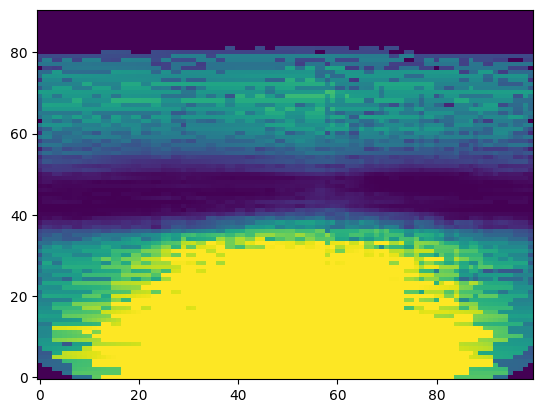

In [23]:
plt.imshow(s_bkg.reshape(center_pts.shape[:-1]).detach().cpu().sum(0), origin='lower', aspect='auto', vmax=20)

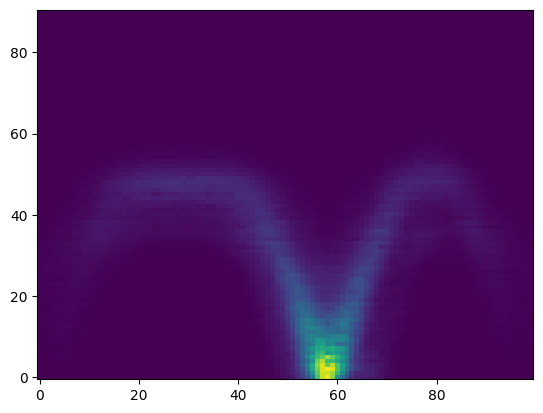

In [24]:
plt.imshow(s_sig.reshape(center_pts.shape[:-1]).sum(0), origin='lower', aspect='auto')

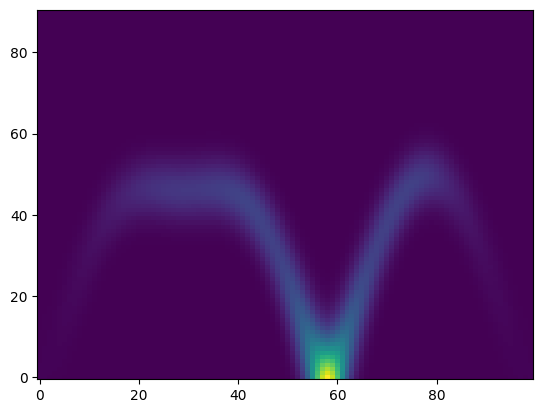

In [25]:
plt.imshow(model_sqw.forward_qw(center_pts.to(device)).cpu().sum(0), origin='lower', aspect='auto')

In [26]:
S_exp = 0.
mask_exp = 0.
for _qw_coords in qw_coords:
    S_exp += experiment.get_measurements_on_coords(_qw_coords)
    mask_exp += experiment.get_mask_on_coords(_qw_coords)

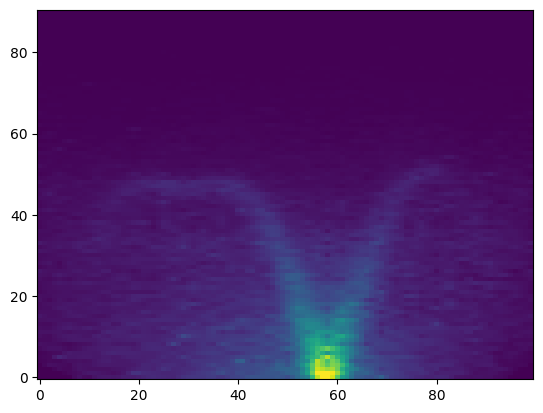

In [27]:
plt.imshow(S_exp, origin='lower', aspect='auto', vmax=300)

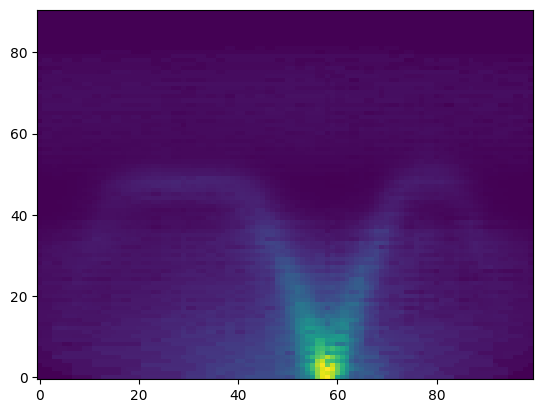

In [28]:
S_exp_pred = (s_sig+s_bkg).reshape(center_pts.shape[:-1]).detach().cpu().sum(0)
plt.imshow(S_exp_pred, origin='lower', aspect='auto', vmax=300)

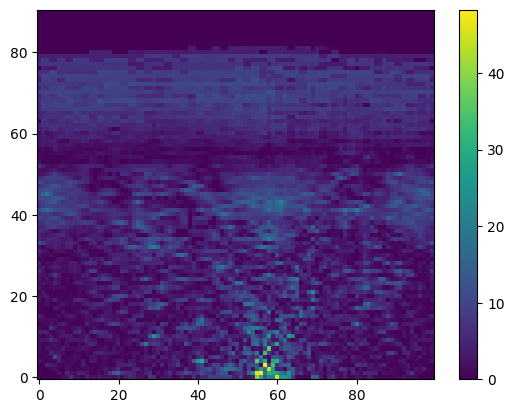

In [29]:
plt.imshow(np.abs(S_exp_pred - S_exp), origin='lower', aspect='auto')
plt.colorbar()

In [30]:
S_mask = data_dict['S'] > 1e-3

In [31]:
batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 2500)

In [32]:
center_pts_full_grid = hklw_grid.reshape(-1,4)
s_sig_full_grid = torch.zeros((data_dict['S'].numel(), 1,))
s_bkg_full_grid = torch.zeros_like(s_sig_full_grid)

batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 2000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts_full_grid[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig_full_grid[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg_full_grid[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

100%|██████████| 2000/2000 [44:26<00:00,  1.33s/it]


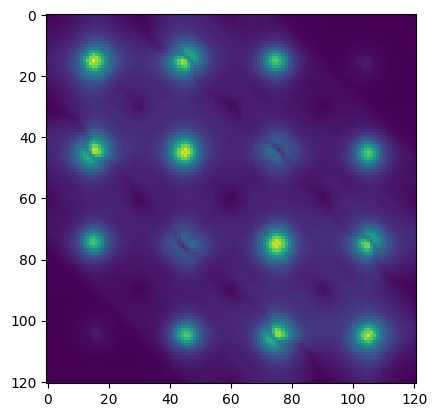

In [33]:
plt.imshow(s_sig_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

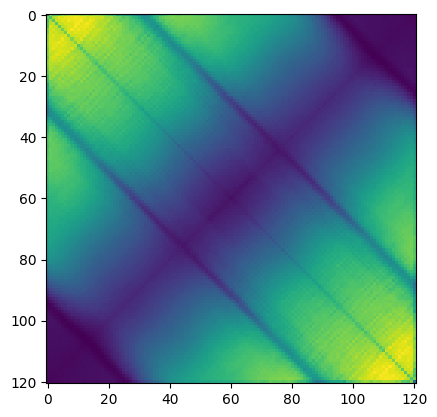

In [34]:
plt.imshow(s_bkg_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

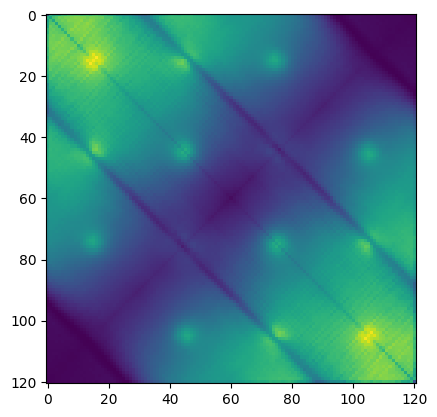

In [35]:
plt.imshow((s_bkg_full_grid+s_sig_full_grid).reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))